In [1]:
#this function computes the update (also called correction)
#step of the filter
#inputs:
#  mu: mean, 
#  sigma: covariance of the robot (x,y.theta)
#  landmarks: a structure of landmarks, we can fetch the
#            position of a landmark given its index
#            by using the tools in the library
#  observations:
#            a structure containing n observations of landmarks
#            for each observation we have
#            - the index of the landmark seen
#            - the location where we have seen the landmark (x,y) w.r.t the robot
#outputs:
#  [mu, sigma]: the updated mean and covariance

function [mu, sigma] = correction(mu, sigma, landmarks, observations)

  % determine how many landmarks we have seen
  num_landmarks_seen = length(observations.observation);
  
  % dimension of the state in dim, in our case is fixed to 3
  state_dim = size(mu,1);

  %if I've seen no landmarks, i do nothing
  if (num_landmarks_seen==0)
    return;
  endif
  
  # we precompute some quantities that come in handy later on
  mu_x = mu(1);
  mu_y = mu(2);
  mu_theta = mu(3);
  c=cos(mu_theta);
  s=sin(mu_theta);
  Rt=[c,s;-s c]; # transposed rotation matrix
  Rtp=[-s,c;-c,-s]; # derivative of transposed rotation matrix

  # here in one go, we go through all landmark measurements vector
  # for each landmark, we assemble
  # the "total" measurement vector, containing all stacked measures
  # the "total" prediction vector, containing all staked predictions
  # the "total" jacobian, consisting of all jacobians of predictions stacked
  # octave allows to "Add" rows to a matrix, thus we dynamically resize them
  
  for i=1:num_landmarks_seen
    %retrieve info about the observed landmark
    measurement = observations.observation(i);

    z_t(end+1,:) = measurement.x_pose; % where we see the landmark
    z_t(end+1,:) = measurement.y_pose;

    current_land = searchById(landmarks, measurement.id);
    lx = current_land.x_pose; % its absolute (true) position
    ly = current_land.y_pose;

    %where I should see that landmark
    l = [lx; ly];
    t=[mu_x ; mu_y];
    measure_prediction = Rt*(l-t);

    h_t(end+1,:) = measure_prediction(1);
    h_t(end+1,:) = measure_prediction(2);

    %compute its Jacobian
    C=zeros(2,state_dim);
    C(1:2,1:2)=-Rt;
    C(1:2,state_dim)=Rtp*(l-t);
    C_t(end+1,:) = C(1,:);
    C_t(end+1,:) = C(2,:);
  endfor


  %observation noise
  noise = 0.01;
  sigma_z = eye(2*num_landmarks_seen)*noise;
  %Kalman gain
  K = sigma*C_t'*(inv(C_t*sigma*C_t' + sigma_z));
  %update mu
  error = (z_t - h_t);
  correction = K*error;
  mu = mu + correction;

  %update sigma
  sigma = (eye(state_dim) - K*C_t)*sigma;
end


In [2]:
#this function implements the kalman prediction step of our localizing robot
# inputs: 
#   transition: is a data structure containing several things,
#               coming from the simulator
#               of these we are interested only in the offset
#               accessible through the "v" field of the structure
#               
#               transition.v(1)=offset x
#               transition.v(2)=offset y (ignore for a diff drive robot)
#               transition.v(3)=offset theta 
#  mu: is the mean of (x,y,theta) the previously estimated robot pose
#  sigma: is the mean of the previously estimated robot pose (3x3 matrix)

# outputs 
# [mu, sigma] are mean and covariance of the estimate after transition

function [mu, sigma] = prediction(mu, sigma, transition)


    u = transition.v;
    %it returns u = [ux, uy, utheta]. simply not consider uy

    %predict mu // this is our f(x,u) function in the slides
    mu = transition_model(mu, u);

    mu_x = mu(1);
    mu_y = mu(2);
    mu_theta = mu(3);

    u_x = u(1);
    u_theta = u(3);

    s = sin(mu_theta);
    c = cos(mu_theta);

    %Jacobian A
    A = [1, 0, -u_x*s;
        0, 1, u_x*c;
        0, 0, 1];


    %Jacobian B
    B = [ c 0;
          s 0;
          0 1];


    %motion noise
    noise = 0.1; %constant part
    v_noise = u_x^2; %lin vel dependent part
    w_noise = u_theta^2; %ang vel dependent part

    sigma_u = [noise^2 + v_noise, 0; 0, noise^2 + w_noise];


    %predict sigma
    sigma = A*sigma*A' + B*sigma_u*B';

end


In [3]:
% this function computes the transition of the robot after incorportating
% a movement u = [ux, uy, u_theta]
% in case of a differential drive robot, ignore uy (the case seen in the classroom)
% inputs:
%   u(1): offset on x
%   u(2): offset on y // ignore in case of differential drive
%   u(3): offset on theta

%   mu(1): x coord of robot w.r.t world
%   mu(2): y coord of robot w.r.t world
%   mu(3): angle of robot w.r.t world

% outputs:
%   mu_prime(1): x coord of robot w.r.t world, after transition
%   mu_prime(2): y coord of robot w.r.t world, after transition
%   mu_prime(3): angle of robot w.r.t world, after transition

function mu_prime = transition_model(mu, u)

    mu_prime = mu;
    mu_x = mu(1);
    mu_y = mu(2);
    ux = u(1);
    utheta = u(3);
    mu_theta = mu(3);
    c = cos(mu_theta);
    s = sin(mu_theta);

    % (x' ) = (    x + ux*cos(th))
    % (y' ) = (    y + ux*sin(th))
    % (th') = (    th + uth)

    mu_prime(1) = mu_x + ux*c;
    mu_prime(2) = mu_y + ux*s;
    mu_prime(3) = mu_theta + utheta;

end

    loadG2o at line 50 column 6
[G2oWrapper] loading file...
#landmarks: 25 
#poses: 137 
#transitions: 136 
#observation(bearing-only): 0 
#observation(point): 136 
#laser-scan: 0 
Random initial pose: [-3.099712, 7.646815, -1.710930]
current pose: [-3.512410, -0.518558, -0.917260]
current pose: [-0.105117, -3.361813, -0.123977]
current pose: [0.917436, -2.081268, 0.239734]
current pose: [0.407270, -1.515259, 0.183829]
current pose: [0.587002, -1.201413, 0.221416]
current pose: [0.736215, -0.994245, 0.267831]
current pose: [0.963284, -0.862086, 0.373344]
current pose: [1.152684, -0.733219, 0.458932]
current pose: [1.346496, -0.592479, 0.515504]
current pose: [1.691344, -0.348832, 0.557424]
current pose: [2.046877, -0.083568, 0.605320]
current pose: [2.359205, 0.165264, 0.630511]
current pose: [2.606083, 0.372282, 0.655384]
current pose: [2.886543, 0.617165, 0.676127]
current pose: [3.183179, 0.878892, 0.719771]
current pose: [3.481409, 1.158317, 0.780159]
current pose: [3.758848, 1.44

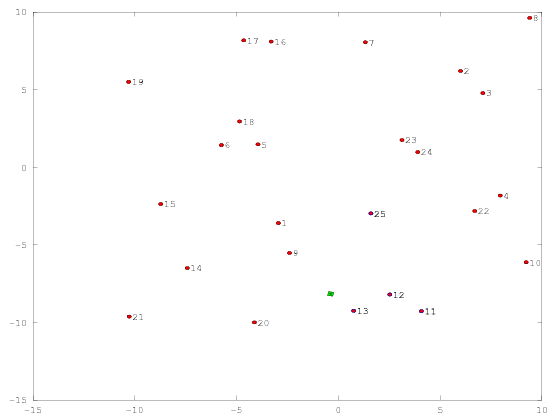

In [4]:
%plot inline
addpath '../'
addpath '../tools/g2o_wrapper'
addpath '../tools/visualization'
source "../tools/utilities/geometry_helpers_2d.m"

%addpath "./exercise" % uncomment this line to target the exercise
%addpath "./solution"

%load your own dataset dataset
[landmarks, poses, transitions, observations] = loadG2o('datasets/dataset_point.g2o');

%% init stuff
%initial pose
mu = rand(3,1)*20-10; 
mu(3) = normalizeAngle(mu(3));
printf('Random initial pose: [%f, %f, %f]\n', mu(1),mu(2), mu(3));
fflush(stdout);

%init covariance
sigma = eye(3)*0.001;

%init graphics
figure(1); title("ekf-localization");
plot_state(landmarks, mu);

%simulation cycle
for i=1:length(transitions)

    %predict
    [mu, sigma] = prediction(mu, sigma, transitions(i));

    %correct
    [mu, sigma] = correction(mu, sigma, landmarks, observations(i));

    printf('current pose: [%f, %f, %f]\n', mu(1),mu(2), mu(3));
    %fflush(stdout);

    %plot current situation
    pause(.1)
    plot_state(landmarks, mu, sigma, observations(i));
    %hold off;
endfor

disp('mu = '), disp(mu');